In [1]:
import requests 
from urllib.parse import urlencode 

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import numpy as np
from tqdm.auto import tqdm

from scipy import stats
from scipy.stats import norm

import pandahouse as ph

## Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

*1. Считываю данные*

In [2]:
def get_direct_url(url):
    '''получить прямую ссылку на яндекс диске'''
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    
    return response.json()['href']

In [3]:
groups = pd.read_csv(get_direct_url('https://disk.yandex.ru/d/58Us0DWOzuWAjg'), sep=';')
groups_add = pd.read_csv(get_direct_url('https://disk.yandex.ru/d/3aARY-P9pfaksg'))
active_studs = pd.read_csv(get_direct_url('https://disk.yandex.ru/d/prbgU-rZpiXVYg'))
checks = pd.read_csv(get_direct_url('https://disk.yandex.ru/d/84hTmELphW2sqQ'), sep=';')

*2. Предварительный анализ данных.*

*Смотрю на размеры таблиц, типы данных, наличие дубликатов и пропущенных значений.*

In [4]:
# Таблица groups

groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.shape

(74484, 2)

In [6]:
groups.dtypes

id      int64
grp    object
dtype: object

In [7]:
groups.loc[groups.duplicated()]

,id,grp


In [8]:
groups.id.nunique()==groups.shape[0]

# Дубликатов нет.

True

In [9]:
groups.isna().sum()

# Пропущенных значений нет.

id     0
grp    0
dtype: int64

In [10]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [11]:
# Таблица groups_add

groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
groups_add.shape

(92, 2)

In [13]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
groups_add.loc[groups_add.duplicated()]

,id,grp


In [15]:
groups_add.id.nunique()==groups_add.shape[0]

# Дубликатов нет.

True

In [16]:
groups_add.isna().sum()

# Пропущенных значений нет.

id     0
grp    0
dtype: int64

In [17]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [18]:
# Таблица active_studs

active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [19]:
active_studs.shape

(8341, 1)

In [20]:
active_studs.student_id.nunique()

8341

In [21]:
active_studs.dtypes

student_id    int64
dtype: object

In [22]:
active_studs.loc[active_studs.duplicated()]

,student_id


In [23]:
active_studs.student_id.nunique()==active_studs.shape[0]

# Дубликатов нет.

True

In [24]:
active_studs.isna().sum()

# Пропущенных значений нет.

student_id    0
dtype: int64

In [25]:
# Таблица checks

checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [26]:
checks.shape

(541, 2)

In [27]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [28]:
checks.loc[checks.duplicated()]

,student_id,rev


In [29]:
checks.student_id.nunique()==checks.shape[0]

# Дубликатов нет.

True

In [30]:
checks.isna().sum()

# Пропущенных значений нет.

student_id    0
rev           0
dtype: int64

*3. Предварительная обработка данных.*

*Объединяю таблицы, фильтрую данные.*

*3.1 Объединяю df:*

*groups - информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа);*

*groups_add - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.*

In [31]:
concatenated_data = pd.concat([groups, groups_add], axis=0)

In [32]:
concatenated_data.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [33]:
concatenated_data.shape

(74576, 2)

In [34]:
# Проверка.

concatenated_data.shape[0] == groups.shape[0] + groups_add.shape[0]

True

*3.2*

*В df active_studs находится информация о пользователях, которые зашли на платформу в дни проведения эксперимента (и их больше чем студентов, которые принимают участие в эксперименте).*

*В df concatenated_data находится информация о пользователях, которые участвуют в эксперименте.*

*Проверяю, все ли студенты из concatenated_data (разбивка по контрольной и экспериментальной группам) посетили платформу в дни эксперимента.*


In [35]:
concatenated_data.loc[concatenated_data.id.isin(active_studs.student_id)].shape[0]

# Из 74576 пользователей, которые потенциально участвуют в эксперименте, 
# только 8341 зашли на платформу в дни эксперимента.

8341

In [36]:
concatenated_data.loc[~concatenated_data.id.isin(active_studs.student_id)].shape[0]

# Из эксперимента "выбыло" 66235 пользователя.

66235

In [37]:
# Проверка.

concatenated_data.loc[concatenated_data.id.isin(active_studs.student_id)].shape[0] + concatenated_data.loc[~concatenated_data.id.isin(active_studs.student_id)].shape[0] == concatenated_data.shape[0]

True

*3.3 Добавляю информацию об оплатах в дни проведения эксперимента из checks.*

In [38]:
# Сохраняю информацию о пользователях, которые участвуют в эксперименте и посетили платформу в дни эксперимента, 
# в отдельный df.

filtered_data = concatenated_data.loc[concatenated_data.id.isin(active_studs.student_id)]

In [39]:
filtered_data.head()

,id,grp
1,1627,A
10,2085,B
12,2215,B
43,3391,A
45,3401,B


In [40]:
# Проверяю, сколько из них оплатили услуги.

filtered_data.loc[filtered_data.id.isin(checks.student_id)].shape[0]

# Из 8341 пользователей, участвующих в эксперименте и посетивших платформу в дни эксперимента, оплатило услуги 392.

392

In [41]:
checks.loc[~checks.student_id.isin(filtered_data.id)].shape[0]

# Пользователи, по которым нет информации об активности на платформе в дни эксперимента, но есть чеки об оплате.

149

In [42]:
# Проверяю, есть ли эти пользователи в таблице concatenated_data, которая содержит информацию о разбивке пользователей на группы.
# Они действительно есть в этой таблице, что нормально, т.к. процесс выборки пользователей для эксперимента является случайным.

concatenated_data.loc[concatenated_data.id.isin(checks.loc[~checks.student_id.isin(filtered_data.id)].student_id)].shape[0]

149

"Осталось" 149 оплат, залогининых как оплаты, проведенные в дни эксперимента, но информации про активность этих пользователей в таблице active_studs нет.

Есть вариант, что произошел сбой, и данные пользователи не попали в таблицу active_studs по каким-либо причинам.

Другое предположение заключается в следующем: например, пользователь посетил сайт за несколько минут до начала эксперимента, перешел на страницу оплаты, у него ушло какое-то время на заполнение формы для оплаты, транзакция прошла как раз в момент "выкатки" эксперимента, поэтому чек этого пользователя попал в базу данных по эксперименту, в то время как "активность" не была "зарегестрирована". Т.К. нет более конкретной информации о том, что считается активностью,  длительности сессии, даты и времени транзакции и даты и времени начала эксперимента, нет возможности проверить это предположение. Но если это предположение верно, то эти 149 оплат были совершены до "выкатки" новой механики оплаты, исходя из чего не следует использовать данную информацию в дальнейшем анализе.

В дальнейшем анализе работаю с пользователями, которые:
1. участвуют в эксперименте, т.е. которые отнесены либо к контрольной, либо к экспериментальной группе;
2. зашли на платформу в дни проведения эксперимента.

Использую left join к filtered_data.

In [43]:
data = filtered_data.merge(checks, how='left', left_on=['id'], right_on=['student_id']).drop(columns='student_id')

In [44]:
data.shape

(8341, 3)

In [45]:
data.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN


In [46]:
# Проверяю сколько переменных относится к тому или иному уровню по колонке grp.

data.grp.value_counts()

# В целевую группу попало 6803 пользователя, в контрульную - 1538, размеры выборок сильно отличаются, 
# большая разница в размерах выборок влияет на мощность статистических критериев, это нужно учитывать.

B    6803
A    1538
Name: grp, dtype: int64

In [47]:
# Заполняю пропущенные значения.

data.rev = data.rev.fillna(0)

In [48]:
# Проверяю сколько пользователей оплатили услуги в контрольной и целевой группах.

data \
    .query('rev!=0') \
    .grp.value_counts()

# В целевой группе услуги оплатило 314 пользователя, в контрольной - 78.

B    314
A     78
Name: grp, dtype: int64

*4. Анализ итогов эксперимента.*

Подсчет метрик.

In [49]:
# Подсчет количества посетилей(visits) и покупателей(buys).

data_metrics = data \
            .groupby('grp', as_index=False) \
            .agg({'id': 'count'}) \
            .rename(columns={'id':'visits'}).merge (
          data \
            .query('rev>0') \
            .groupby('grp', as_index=False) \
            .agg({'id': 'count'}) \
            .rename(columns={'id':'buys'}), on='grp')
data_metrics

,grp,visits,buys
0,A,1538,78
1,B,6803,314


In [50]:
# Подсчет CR.

data_metrics['CR'] = data_metrics.buys/data_metrics.visits
data_metrics

,grp,visits,buys,CR
0,A,1538,78,0.050715
1,B,6803,314,0.046156


In [51]:
# Подсчет revenue.

data_metrics = data_metrics.merge(data \
                                        .groupby('grp', as_index=False) \
                                        .agg({'rev': 'sum'}).round(2) \
                                        .rename(columns={'rev':'revenue'}),
                            on='grp')
data_metrics

,grp,visits,buys,CR,revenue
0,A,1538,78,0.050715,72820.0
1,B,6803,314,0.046156,394974.0


In [52]:
# Подсчет средний чек (aver_check).

data_metrics['aver_check'] = round(data_metrics.revenue / data_metrics.buys, 2)

In [53]:
# Подсчет повторных покупок (в данном случае каждый покупатель совершил по одной покупке).

data_metrics['repeat_purchases'] = data_metrics.buys / data_metrics.buys

In [54]:
# Подсчет ARPPU.

data_metrics['ARPPU'] = data_metrics.aver_check * data_metrics.repeat_purchases

In [55]:
# Подсчет ARPU.

data_metrics['ARPU'] = round(data_metrics.CR * data_metrics.ARPPU, 2)

In [56]:
data_metrics

,grp,visits,buys,CR,revenue,aver_check,repeat_purchases,ARPPU,ARPU
0,A,1538,78,0.050715,72820.0,933.59,1.0,933.59,47.35
1,B,6803,314,0.046156,394974.0,1257.88,1.0,1257.88,58.06


В целевой группе средний чек, ARPU, ARPPU выше, чем в контрольной.
Проверяю, статзначимы различия среднего чека между группами или нет.

In [57]:
# Смотрим на значения описательных статистик.
# Для контрольной группы А медиана и среднее значение сильно отличаются -> 
# есть выбросы, которые "оттягивают" среднее значение в бОльшую сторону. 
data \
    .query('rev>0') \
    .pivot(index='id', columns='grp', values='rev').describe()

grp,A,B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


<AxesSubplot:xlabel='rev', ylabel='Count'>

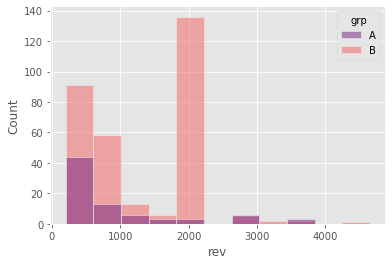

In [58]:
# Смотрим на распределения значений сумм оплат для каждой группы.

sns.histplot(data=data.query('rev>0'), x="rev", hue="grp", palette='magma')

# Распределения явно отличаются от нормального.

<AxesSubplot:xlabel='grp', ylabel='rev'>

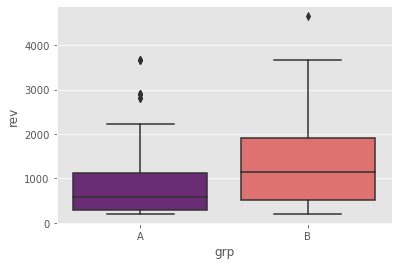

In [59]:
# На графике типа boxplot видны "выбросы" (не совсем выбросы, ведь это реальные суммы оплат, но в контексте общего распределения данных - "выбросы").

sns.boxplot(x='grp', y='rev', data=data.query('rev>0'), palette='magma')

Тест Шапиро-Уилка для проверки нормальности распределений.

Н0 : величина rev распределена нормально;\
Н1 : величина rev распределена не нормально.

In [60]:
# Предобработка данных. Сохраняю значения сумм оплат по группам в отдельные переменные.

dataA = data.query('rev>0 & grp == "A"').rev
dataB = data.query('rev>0 & grp == "B"').rev

In [61]:
# Тест Шапиро-Уилка для группы А.

stats.shapiro(dataA)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [62]:
stats.shapiro(dataA)[1] < 0.05

# Отклоняем Н0, данные имеют не нормальное распределение (при α = 0.05).

True

In [63]:
# Тест Шапиро-Уилка для группы В.

stats.shapiro(dataB)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

In [64]:
stats.shapiro(dataB)[1] < 0.05

# Отклоняем Н0, данные имеют не нормальное распределение (при α = 0.05).

True

Тест Левена для проверки гомогенности дисперсии.

Н0 : дисперсии совокупностей, из которых взяты выборки контрольной и целевой групп, одинаковы;\
Н1 : дисперсии отличаются.

In [65]:
stats.levene(dataA, dataB)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

In [66]:
stats.levene(dataA, dataB)[1] < 0.05

# принимаем Н0, дисперсии примерно одинаковы (при α = 0.05).

False

In [67]:
# Дисперсия каждой группы.

[np.var(x, ddof=1) for x in [dataA, dataB]]

[846276.1931401932, 625466.2680387263]

t-тест на больших выборках стабильно работает, даже если не соблюдается требование нормальности распределения (работает ЦПТ) -> с одной стороны наш случай, с другой стороны с ненормально распределенными данными и пограничными результатами теста на однородность дисперсии (pvalue=0.08) безопаснее выбрать бутстрап или непарметрический аналог t-теста.

Однако в нашем случае мощность непараметрического аналога U-критерия Манна-Уитни будет страдать из-за большой разницы в размерах выборок, да и интерпретировать результаты этого теста сложнее, т.к. сравниваются распределения.

Поэтому мой выбор в данном случае - бутстрап.

H0 : средние значения оплат двух групп (А, В) не отличаются;\
H1 : средние значения оплат двух групп (А, В) отличаются.

In [68]:
# Объявим функцию для проведения botstrap анализа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=100,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

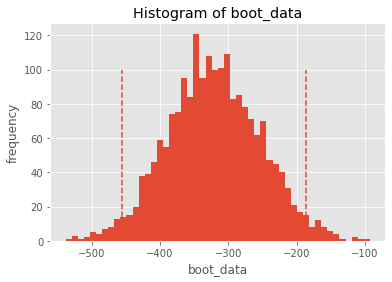

p-value = 2.2328941129882266e-06


In [69]:
booted_data = get_bootstrap(dataA, dataB, boot_it=2000)
print(f'p-value = {booted_data["p_value"]}')

p-value < 0.05, 0 не попадает в доверительный интервал при заданном уровне значимости 95% -> отклоняем нулевую гипотезу о равенстве средних значений оплат в группах.

В целевой группе CR ниже, чем в контрольной.
Проверю, статистически достоверны эти различия или нет.

H0 : взаимосвязи между группой эксперимента и количеством покупок нет;\
H1 : существует взаимосвязь между группой эксперимента и количеством покупок.

Т.к. данные категориальные для проверки гипотез буду использовать таблицу сопряженности и критерий хи-квадрат.

In [70]:
# Добавляю столбец buy, который имеет два уровня: 1-есть оплата, 0-нет оплаты.

data['buy'] = data.rev.apply(lambda x: 1 if x>0 else 0)

In [71]:
# Строю таблицу сопряженности.

data_CR = pd.crosstab(data.grp, data.buy)
data_CR

buy,0,1
grp,,
A,1460,78
B,6489,314


In [72]:
# Расчет статистики, p-value.

stat, p, dof, expected = stats.chi2_contingency(data_CR)

In [73]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [74]:
# Результаты.

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Взаимосвязь между группой эксперимента и количеством покупок не была обнаружена в данном эксперименте при заданном уровне значимости.

**Вывод:**

В целом в целевой группе статзначимо вырос средний чек в сравнении с контрольной группой,
в то время как конверсия упала, но различия оказались незначимы -> можно запускать новую механику оплаты на всех пользователей.

Однако интересной особенностью данных является пик в целевой группе в районе 1900у.е. Кажется, что следует собрать дополнительную информацию о пользователях и деталях покупок, кластеризовать -> возможно получится выявить группу пользователей или группу услуг, которая и соответствует этому пику. Провести соответствующий анализ и тогда, возможно, эффективнее и целесообразнее будет запускать новую механику оплаты именно на эту группу пользователей/тип услуги.


## Задание 2. SQL

In [75]:
connection_default = {'host': 'your_host',
                      'database':'your_database',
                      'user':'your_user', 
                      'password':'your_password'
                     }

**2.1 Очень усердные ученики.**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [76]:
q_1 = '''
    SELECT
        COUNT(diligent_students) AS diligent_students_count
    FROM(
        SELECT 
            st_id AS diligent_students
        FROM 
            peas
        WHERE
            toStartOfMonth(timest) = '2020-03-01' AND
            correct = 1 
        GROUP BY
            st_id
        HAVING COUNT(correct)>=20
        )
    '''

In [77]:
ph.read_clickhouse(query=q_1, connection=connection_default)

,diligent_students_count
0,0


**2.2 Оптимизация воронки**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей: ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку, CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

В этом задании (для получения более интересных результатов, тренировки навыков, и поскольку не была прописана четкая логика по отнесению каждого пользователя к определенной группе в испытании (в данных есть аномалии: каждый пользователь есть и в old, и в new группах)), я отнесла каждого пользователя к определенной группе (old, new) по частоте их представленности (old, new) в таблице studs.

В этом задании под **активным** пользователем (для получения более интересных результатов) я принимала пользователя, который **совершал** "действия" в рамках курсов, которые он купил, также пользователь был активен на сайте **за последний месяц (именно solution_time)**. я отталкивалась от следующего: если пользователь покупает курс, но не проходит его (нет никакой активности), то интерес к платформе у него быстро угаснет, несмотря на то, что изначально мы заработали на нем, он не перейдет в категорию лояльных пользователей. (Хотя для полноценной реализации этой логики не хватает данных, скорее я хотела потренировать свои навыки).

ПС: запрос был бы меньше, если бы в СУБД для студентов были права для создания представлений.

In [78]:
q_2 = '''
    WITH
    active AS (

    SELECT
        st_id AS active_st_id,
        COUNT(DISTINCT(subject_buy)) AS buy,
        COUNT(DISTINCT(subject_solution)) AS try,
        groupArray(DISTINCT(subject_buy)) AS array_buy,
        groupArray(DISTINCT(subject_solution)) AS array_try,
        hasAll(array_try, array_buy) AS active_users
    FROM(

    SELECT
        l.st_id AS st_id,
        l.sale_time AS sale_time,
        l.money AS money,
        l.subject_buy AS subject_buy,
        l.solution_time AS solution_time,
        l.correct AS correct,
        l.subject_solution AS subject_solution,
        r.test_grp AS test_grp,
        IF(subject_solution = 'Math', 1, 0) AS math_active,
        IF(subject_buy = 'Math', 1, 0) AS math_buy
    FROM(
        SELECT
            l.st_id AS st_id,
            l.sale_time AS sale_time,
            l.money AS money,
            l.subject AS subject_buy,
            r.timest AS solution_time,
            r.correct AS correct,
            r.subject AS subject_solution
        FROM(
            SELECT
                st_id,
                sale_time,
                money,
                subject,
                rowNumberInAllBlocks( ) AS row
            FROM 
                final_project_check
            ) AS l
        JOIN 
        (
            SELECT 
                *,
                rowNumberInAllBlocks( ) AS row
            FROM
                peas
        ) AS r 
        USING(row)) AS l
    LEFT SEMI JOIN (
        SELECT
            st_id,
            test_grp,
            count(*) AS c
        FROM 
            studs
        GROUP BY
            st_id,
            test_grp
        ORDER BY 
            st_id,
            c DESC
        ) AS r
        USING(st_id)

    )
    GROUP BY 
        st_id
    HAVING
        active_users=1
    )


    SELECT
    --    count(DISTINCT(st_id)) AS students_in_grp,
        ROUND(SUM(money)/count(DISTINCT(st_id)), 2) AS ARPU,
        ROUND(sumIf(money, active_students=1)/count(DISTINCT(st_id)), 2) AS ARPAU,
    --    countIf(DISTINCT(st_id), math_active=1) AS math_act,
    --    countIf(DISTINCT(st_id), math_active=1 AND math_buy=1) AS math_act_buy,
    --    ROUND(math_act_buy/math_act*100, 2) AS CR_math,
        ROUND(countIf(DISTINCT(st_id), math_active=1 AND math_buy=1)/countIf(DISTINCT(st_id), math_active=1)*100, 2) AS CR_math,
    --    countIf(DISTINCT(st_id), active_students=1 AND dateDiff('day', solution_time, toDate('2020-12-01')) <= 30) AS active_buy,
    --    countIF(DISTINCT(st_id), dateDiff('day', solution_time, toDate('2020-12-01')) <= 30) AS active_student,
        ROUND(countIf(DISTINCT(st_id), active_students=1 AND dateDiff('day', solution_time, toDate('2020-12-01')) <= 30)/countIF(DISTINCT(st_id), dateDiff('day', solution_time, toDate('2020-12-01')) <= 30)*100, 2) AS CR_active,
        ROUND(countIf(DISTINCT(st_id), money>0)/COUNT(DISTINCT(st_id))*100, 2) AS CR,
        test_grp
    FROM(
        SELECT
            l.st_id AS st_id,
            l.sale_time AS sale_time,
            l.money AS money,
            l.subject_buy AS subject_buy,
            l.solution_time AS solution_time,
            l.correct AS correct,
            l.subject_solution AS subject_solution,
            r.test_grp AS test_grp,
            IF(subject_solution = 'Math', 1, 0) AS math_active,
            IF(subject_buy = 'Math', 1, 0) AS math_buy,
            IF(st_id IN (SELECT active_st_id FROM active), 1, 0) AS active_students
        FROM(
            SELECT
                l.st_id AS st_id,
                l.sale_time AS sale_time,
                l.money AS money,
                l.subject AS subject_buy,
                r.timest AS solution_time,
                r.correct AS correct,
                r.subject AS subject_solution
            FROM(
                SELECT
                    st_id,
                    sale_time,
                    money,
                    subject,
                    rowNumberInAllBlocks( ) AS row
                FROM 
                    final_project_check
                ) AS l
            JOIN 
            (
                SELECT 
                    *,
                    rowNumberInAllBlocks( ) AS row
                FROM
                    peas
            ) AS r 
            USING(row)) AS l
        LEFT SEMI JOIN (
            SELECT
                st_id,
                test_grp,
                count(*) AS c
            FROM 
                studs
            GROUP BY
                st_id,
                test_grp
            ORDER BY 
                st_id,
                c DESC
            ) AS r
            USING(st_id)
        )
    GROUP BY test_grp
    '''

In [ ]:
ph.read_clickhouse(query=q_2, connection=connection_default)

## Задание 3. Python

**3.1**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [80]:
def get_metrics(additional_data_path):
    
    # считываем дополнительный файл
    additional_data = pd.read_csv(additional_data_path)
    
    # объединяем его с основной таблицей
    data_concatenated = pd.concat([groups, additional_data], axis=0)
    
    # отбираем активных юзеров согласно данным из таблицы active_studs
    data_filtered = data_concatenated.loc[data_concatenated.id.isin(active_studs.student_id)]
    
    """
    мержим таблицу с информацией об оплатах
    считаем, что структура таблиц постоянна: 1ая колонка - id
    т.к. в условии сказано, что заголовки могут отличаться, id студентов переводим в индексы, мерджим 
    таблицы по индексам
    """
    data_filtered = data_filtered.set_index(data_filtered.iloc[:,0]).drop(data_filtered.columns[[0]], axis=1)
    checks_m = checks.set_index(checks.iloc[:,0]).drop(checks.columns[[0]], axis=1)
    data_all = pd.merge(data_filtered, checks_m, how = 'left', left_index=True, right_index=True).fillna(0).reset_index()
    
    # добавляем колонку buy, которая имеет 2 уровня: 1-есть оплата, 0-нет оплаты
    data_all['buy'] = data_all.rev.apply(lambda x: 1 if x>0 else 0)
    
    # расчет метрик
    # сколько пользователей посетило платформу (visits) и сколько оплатило услуги (buys)
    metrics_data = data_all \
                        .groupby('grp', as_index=False) \
                        .agg({'id':'count', 'buy':'sum', 'rev':'sum'}) \
                        .rename(columns={'id':'visits', 'buy':'buys', 'rev':'revenue', 'grp':'group'})
    
    # CR
    metrics_data['CR'] = metrics_data.buys / metrics_data.visits
    
    # средний чек
    metrics_data['aver_check'] = round(metrics_data.revenue / metrics_data.buys, 2)
    
    # повторные покупки 
    metrics_data['repeat_purchases'] = metrics_data.buys / metrics_data.buys
    
    # ARPPU
    metrics_data['ARPPU'] = metrics_data.aver_check * metrics_data.repeat_purchases
    
    # ARPU
    metrics_data['ARPU'] = round(metrics_data.CR * metrics_data.ARPPU, 2)
    
    return metrics_data


In [81]:
metrics_data = get_metrics(additional_data_path='/home/alla/Downloads/Проект_2_group_add.csv')

In [82]:
metrics_data

,group,visits,buys,revenue,CR,aver_check,repeat_purchases,ARPPU,ARPU
0,A,1538,78,72820.0000,0.050715,933.59,1.0,933.59,47.35
1,B,6803,314,394974.0035,0.046156,1257.88,1.0,1257.88,58.06


**3.2**

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [83]:
def get_plots(metrics_data):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 13))
    sns.barplot(x =metrics_data.group, y = metrics_data.aver_check, ax=ax[0][0], palette='magma').set_title('Average check').axes.get_yaxis().set_visible(False)
    sns.barplot(x =metrics_data.group, y = metrics_data.CR, ax=ax[0][1], palette='magma').set_title('CR').axes.get_yaxis().set_visible(False)
    sns.barplot(x =metrics_data.group, y = metrics_data.ARPPU, ax=ax[1][0], palette='magma').set_title('ARPPU').axes.get_yaxis().set_visible(False)
    sns.barplot(x =metrics_data.group, y = metrics_data.ARPU, ax=ax[1][1], palette='magma').set_title('ARPU').axes.get_yaxis().set_visible(False)

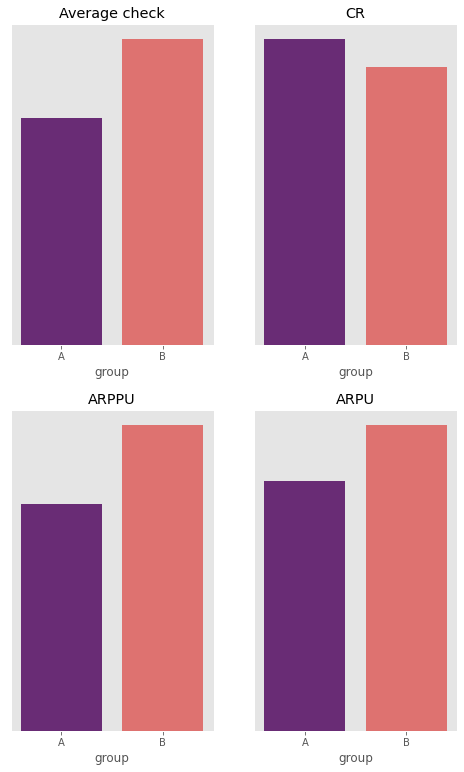

In [84]:
get_plots(metrics_data)